# Model for Pinkeye in goat

In [1]:
import os
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import seaborn as sns

## Load dataset from local

In [2]:
#pinkey goat
folder_path = (r'D:\Kampus Merdeka\Documentation\Goat\train\Pinkeye Goat')
test = os.listdir(folder_path)
for fichier in test: 
    if not(fichier.endswith(".jpg")):
        os.remove(os.path.join(folder_path, fichier))

In [3]:
#healthy goat
folder_path = (r'D:\Kampus Merdeka\Documentation\Goat\train\Healthy Goat')
test = os.listdir(folder_path)
for fichier in test: 
    if not(fichier.endswith(".jpg")):
        os.remove(os.path.join(folder_path, fichier))

In [4]:
#cek label
image_dir = Path(r'D:\Kampus Merdeka\Documentation\Goat\train')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [5]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head(2)

,Filepath,Label
0,D:\Kampus Merdeka\Documentation\Goat\train\Pin...,Pinkeye Goat
1,D:\Kampus Merdeka\Documentation\Goat\train\Pin...,Pinkeye Goat


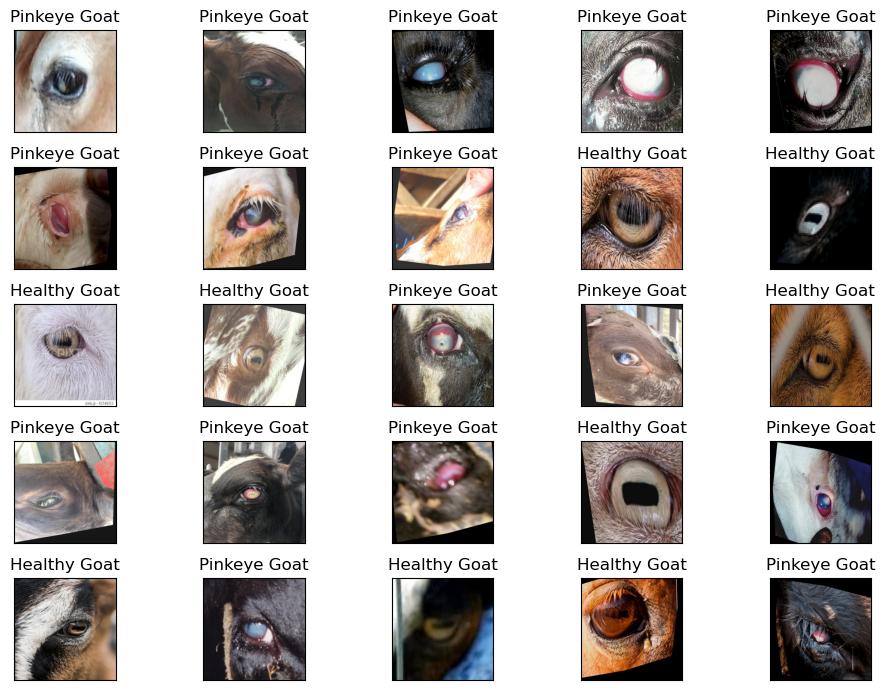

In [6]:
# Display some pictures of the dataset with their labels

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

In [7]:
#Shuffle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
# Separate in train and test data
train_df, validasi_df = train_test_split(image_df, train_size=0.8, shuffle=True, random_state=1)

## Import Depedencies

In [8]:
import tensorflow as tf
from keras import Model, Input
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from keras import layers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

## Using MObileNetV2 for Transfer Learning

In [9]:
input_shape = (180,180,3)
model_input = Input(shape=input_shape)

mobileNet = MobileNetV2(input_shape=input_shape, 
                        input_tensor=model_input, 
                        include_top=False, 
                        weights="imagenet")

for layer in mobileNet.layers:
    layer.trainable = False
    

## Image Augmentation

In [10]:
#data generator
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],
    horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)
                                   
train_data = train_datagen.flow_from_dataframe(dataframe=train_df,
                                          x_col='Filepath',
                                          y_col='Label',
                                         seed=0,
                                         target_size=(180,180),
                                         batch_size=16,
                                         shuffle=True,
                                         class_mode = 'categorical',
                                        subset='training',
                                         )

validasi_data = val_datagen.flow_from_dataframe(dataframe=validasi_df,
                                        x_col='Filepath',
                                        y_col='Label',
                                         seed=0,
                                         target_size=(180,180),
                                         batch_size=16,
                                         shuffle=False,
                                         class_mode = 'categorical',
                                         )

Found 476 validated image filenames belonging to 2 classes.
Found 119 validated image filenames belonging to 2 classes.


## Build the Model

In [11]:
x_mobileNet = mobileNet.output
# Flatten 
x_mobileNet = Flatten(name="flatten")(x_mobileNet)
# Add a fully connected layer with 512 hidden units and ReLU activation
x_mobileNet = Dense(512, activation='relu')(x_mobileNet)
# Add a dropout rate of 0.5
x_mobileNet = Dropout(0.2)(x_mobileNet)
# Add a final softmax layer for classification
x_mobileNet = Dense(2, activation='softmax')(x_mobileNet)

# Configure and compile the model
mobileNet_model = Model(model_input, x_mobileNet)
optimizer = Adam(lr=1e-5)
mobileNet_model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])


C:\Users\Fenny Puspitasari\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


## Make Checkpoint Callback

In [12]:
# ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint('MobileNet_Goat_model_best.h5',
                                      save_best_only=True,
                                      monitor='val_loss',
                                      mode='min', verbose=1)

## Make Checkpoint Callback

In [13]:
import tensorflow as tf
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('loss') < 0.1 and logs.get('val_loss') < 0.1):
      print("\Stopped, Akurasi mencapai 98%")
      self.model.stop_training = True;

## Train the model and save to .h5

In [14]:
callbacks = myCallback()

# Fit the model
history_mobileNet = mobileNet_model.fit(
    train_data,
    validation_data=validasi_data,
    steps_per_epoch=train_data.n//16,
    validation_steps=validasi_data.n//16,
    epochs=50,
    callbacks=[callbacks, checkpoint_callback])

Epoch 1/50
29/29 [==============================] - ETA: 0s - loss: 0.7634 - accuracy: 0.6913
Epoch 1: val_loss improved from inf to 0.53895, saving model to MobileNet_Goat_model_best.h5
29/29 [==============================] - 18s 534ms/step - loss: 0.7634 - accuracy: 0.6913 - val_loss: 0.5389 - val_accuracy: 0.7500
Epoch 2/50
29/29 [==============================] - ETA: 0s - loss: 0.4154 - accuracy: 0.8283
Epoch 2: val_loss improved from 0.53895 to 0.33504, saving model to MobileNet_Goat_model_best.h5
29/29 [==============================] - 15s 524ms/step - loss: 0.4154 - accuracy: 0.8283 - val_loss: 0.3350 - val_accuracy: 0.8661
Epoch 3/50
29/29 [==============================] - ETA: 0s - loss: 0.3425 - accuracy: 0.8804
Epoch 3: val_loss did not improve from 0.33504
29/29 [==============================] - 13s 462ms/step - loss: 0.3425 - accuracy: 0.8804 - val_loss: 0.3418 - val_accuracy: 0.8661
Epoch 4/50
29/29 [==============================] - ETA: 0s - loss: 0.2970 - accuracy

Epoch 28/50
29/29 [==============================] - ETA: 0s - loss: 0.0869 - accuracy: 0.9587
Epoch 28: val_loss did not improve from 0.14291
29/29 [==============================] - 13s 435ms/step - loss: 0.0869 - accuracy: 0.9587 - val_loss: 0.1434 - val_accuracy: 0.9375
Epoch 29/50
29/29 [==============================] - ETA: 0s - loss: 0.0559 - accuracy: 0.9848
Epoch 29: val_loss did not improve from 0.14291
29/29 [==============================] - 13s 434ms/step - loss: 0.0559 - accuracy: 0.9848 - val_loss: 0.1509 - val_accuracy: 0.9286
Epoch 30/50
29/29 [==============================] - ETA: 0s - loss: 0.0665 - accuracy: 0.9717
Epoch 30: val_loss did not improve from 0.14291
29/29 [==============================] - 13s 429ms/step - loss: 0.0665 - accuracy: 0.9717 - val_loss: 0.1551 - val_accuracy: 0.9196
Epoch 31/50
29/29 [==============================] - ETA: 0s - loss: 0.0846 - accuracy: 0.9761
Epoch 31: val_loss did not improve from 0.14291
29/29 [=========================

## Accuracy and Loss History

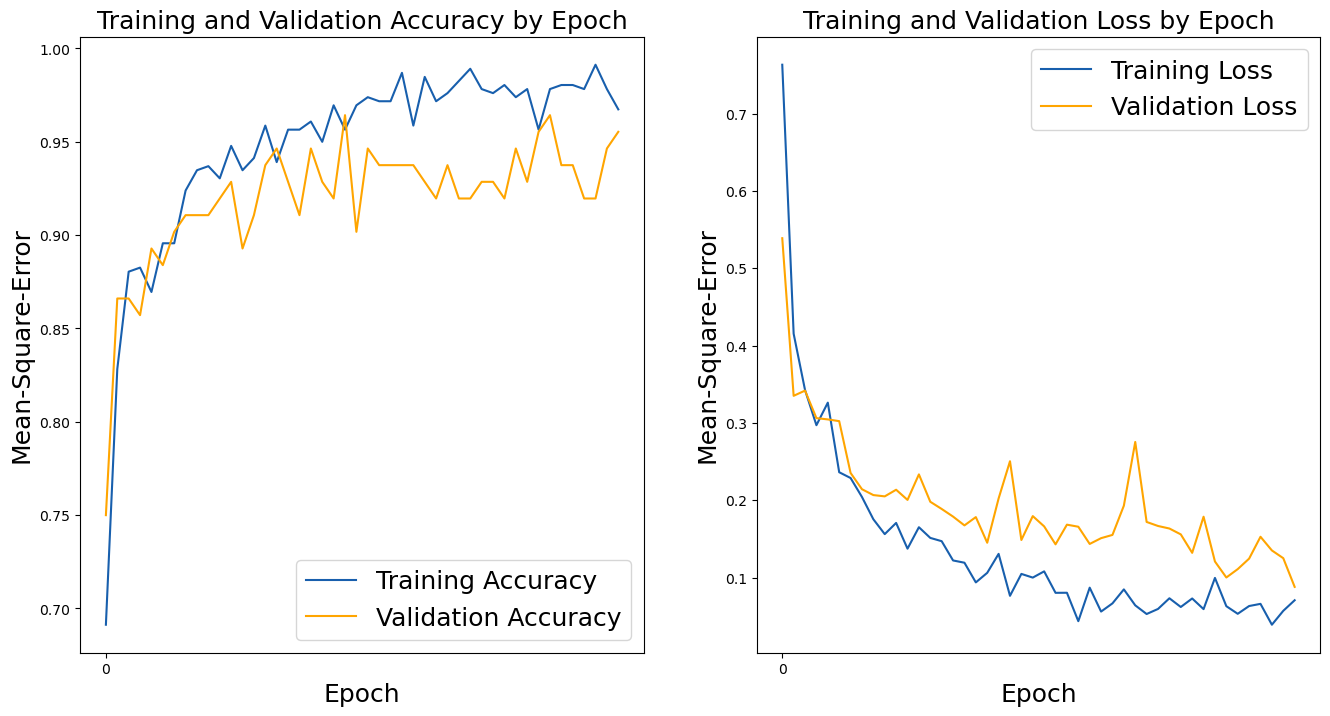

In [15]:
train_accuracy = history_mobileNet.history['accuracy']
val_accuracy = history_mobileNet.history['val_accuracy']
train_loss = history_mobileNet.history['loss']
val_loss= history_mobileNet.history['val_loss']

plt.figure(figsize=(16, 8))

# Cek hasil akurasi
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')

plt.title('Training and Validation Accuracy by Epoch', fontsize = 18)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Mean-Square-Error', fontsize = 18)
plt.xticks(range(0,16,20), range(0,16,20))

plt.legend(fontsize = 18);

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(val_loss, label='Validation Loss', color='orange')

plt.title('Training and Validation Loss by Epoch', fontsize = 18)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Mean-Square-Error', fontsize = 18)
plt.xticks(range(0,16,20), range(0,16,20))


plt.legend(fontsize = 18)

## Confusion Matrix

C:\Users\Fenny Puspitasari\AppData\Local\Temp\ipykernel_14168\385079297.py:47: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = mobileNet_model.predict_generator(validasi_data)


Confusion Matrix
Normalized confusion matrix
Classification Report
              precision    recall  f1-score   support

Healthy Goat       0.97      0.90      0.94        40
Pinkeye Goat       0.95      0.99      0.97        79

    accuracy                           0.96       119
   macro avg       0.96      0.94      0.95       119
weighted avg       0.96      0.96      0.96       119



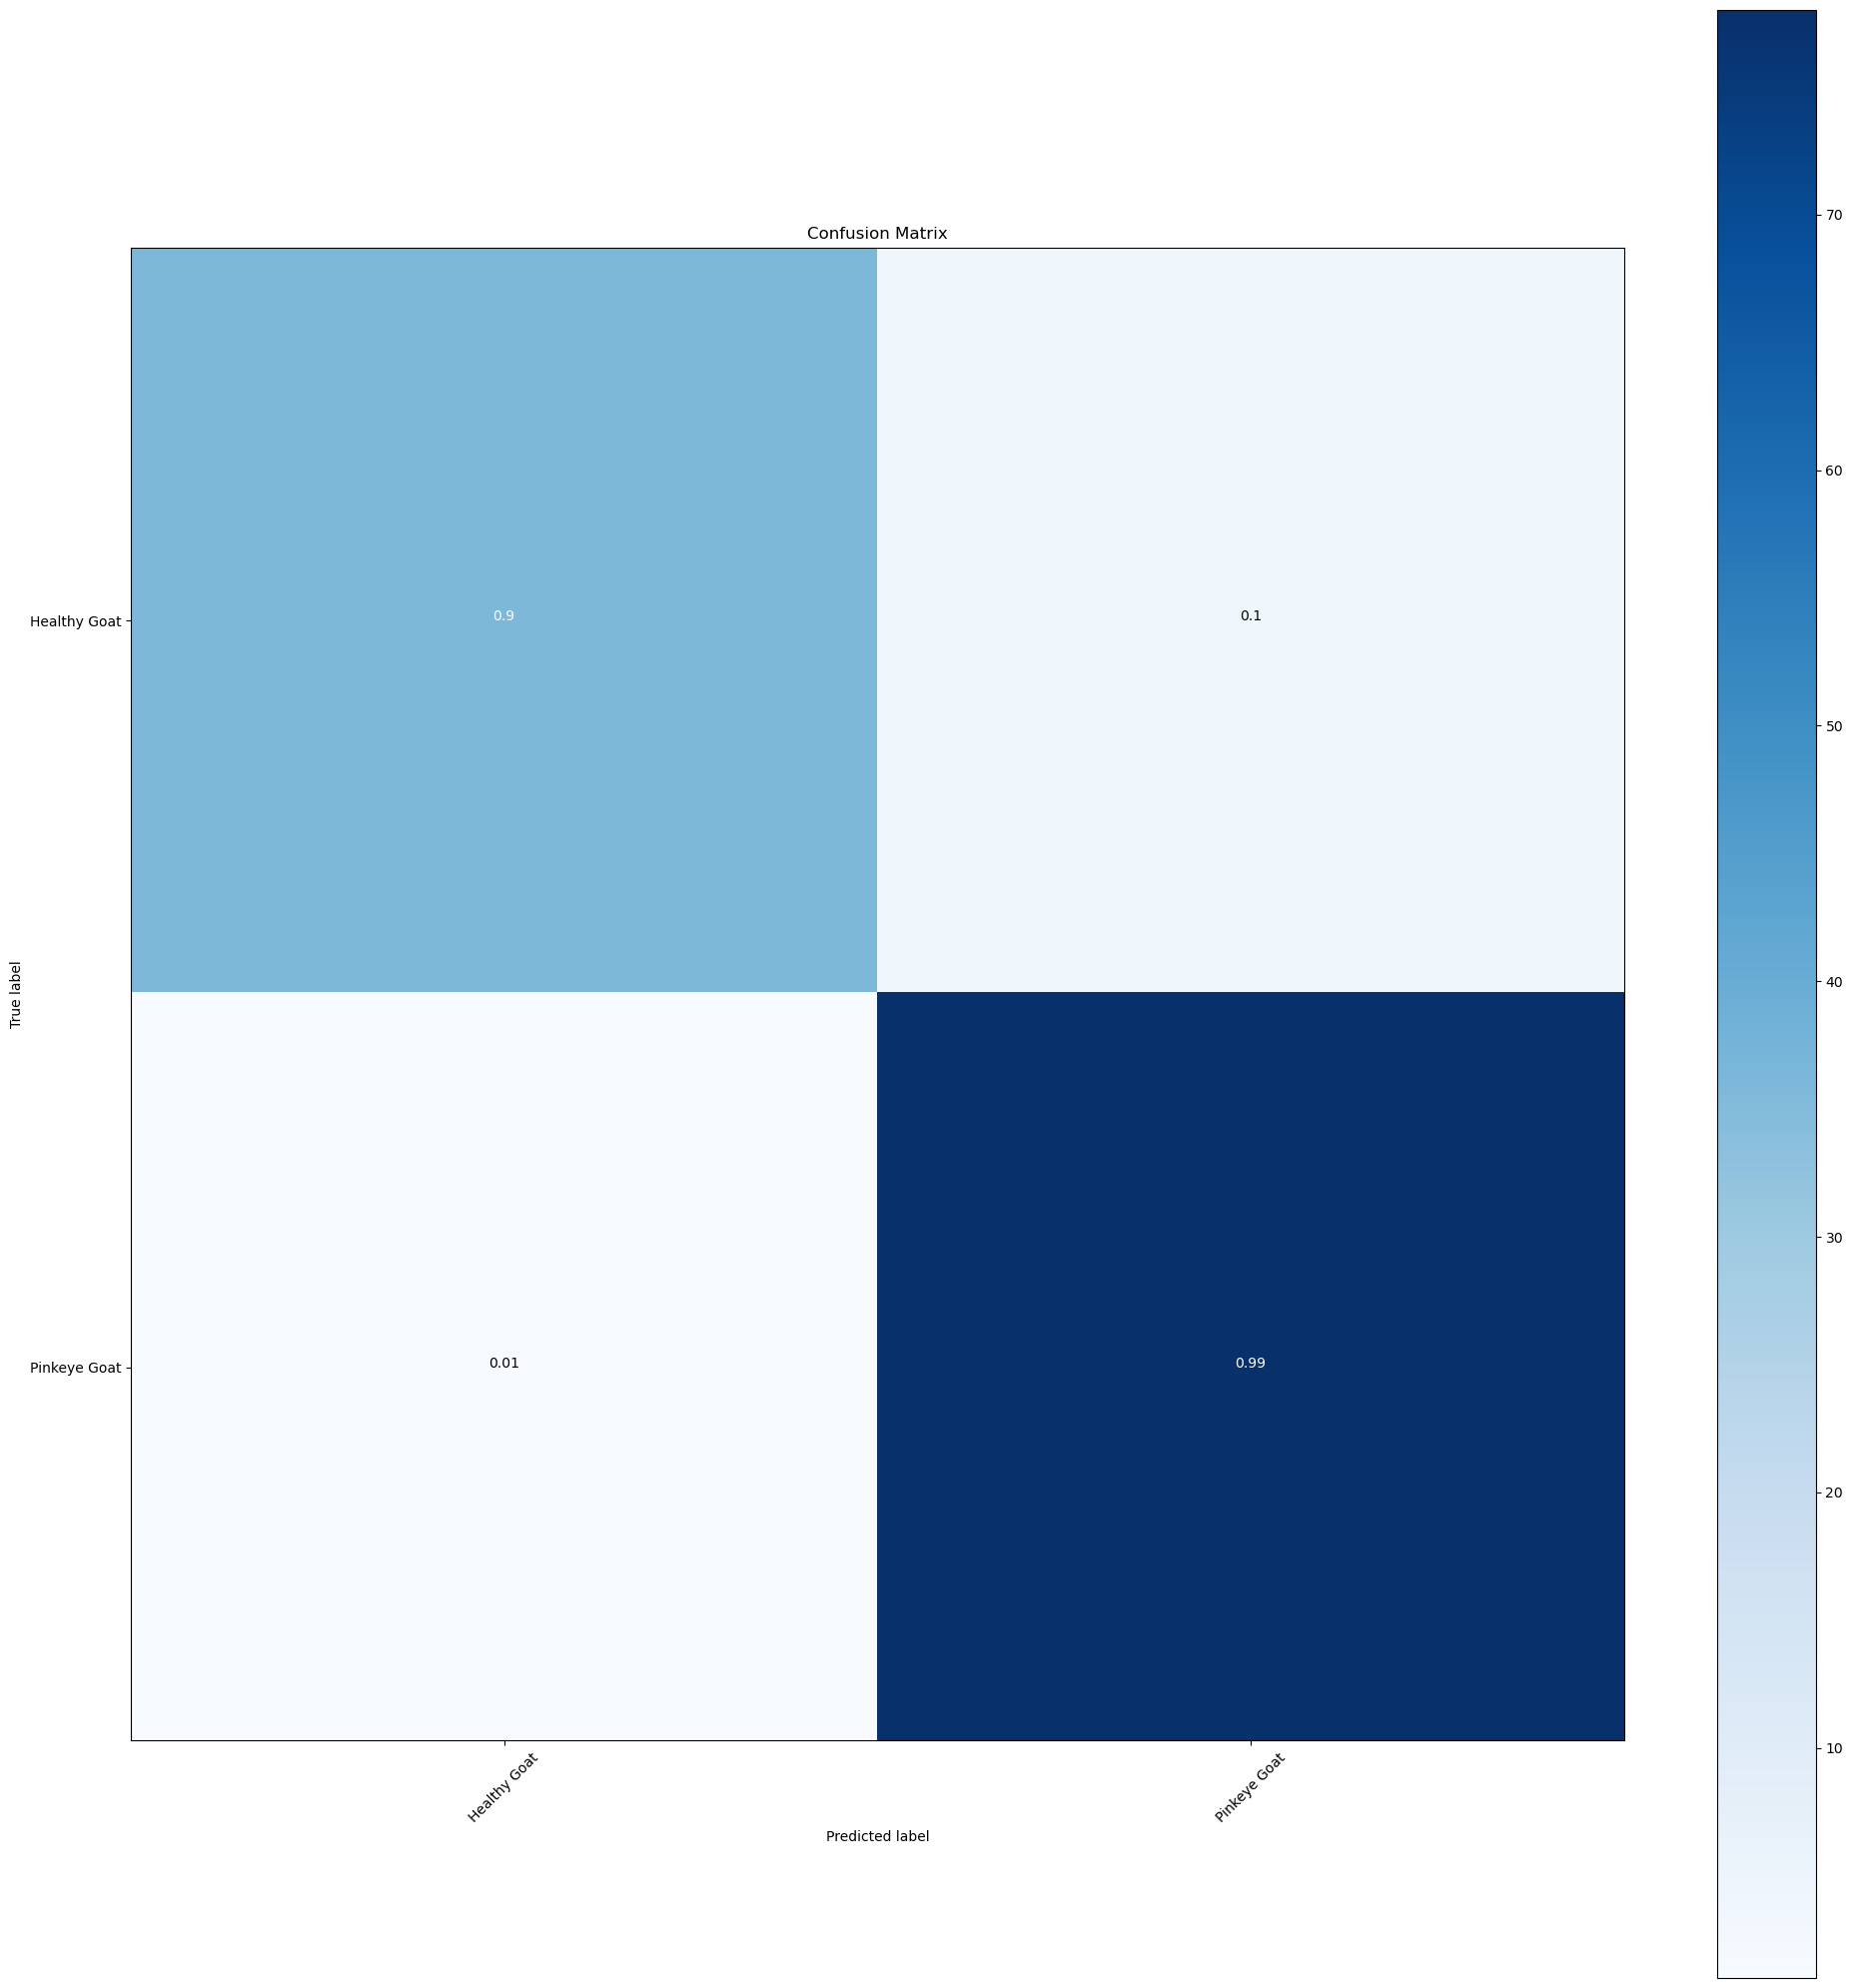

In [16]:
#Plot the confusion matrix. Set Normalize = True/False

def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(20,20))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Print the Target names
from sklearn.metrics import classification_report, confusion_matrix
import itertools 
#shuffle=False

target_names = []
for key in validasi_data.class_indices:
    target_names.append(key)

# print(target_names)

#Confution Matrix 

Y_pred = mobileNet_model.predict_generator(validasi_data)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(validasi_data.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')

#Print Classification Report
print('Classification Report')
print(classification_report(validasi_data.classes, y_pred, target_names=target_names))

## Testing the Model

In [17]:
# Predict the label of the test_images
from tensorflow.keras.models import load_model

# Load the trained model
mobileNet_model = load_model('MobileNet_Goat_model_best.h5')

pred = mobileNet_model.predict(validasi_data)
pred_classes = np.argmax(pred,axis=1)
pred_proba = np.max(pred, axis=1)

# Map the label
labels = (train_data.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred_classes = [labels[k] for k in pred_classes]

# Display the result
print(f'The first 15 predictions: {pred_classes[:15]}')

8/8 [==============================] - 2s 199ms/step
The first 15 predictions: ['Pinkeye Goat', 'Pinkeye Goat', 'Pinkeye Goat', 'Pinkeye Goat', 'Pinkeye Goat', 'Pinkeye Goat', 'Pinkeye Goat', 'Healthy Goat', 'Pinkeye Goat', 'Pinkeye Goat', 'Pinkeye Goat', 'Pinkeye Goat', 'Healthy Goat', 'Healthy Goat', 'Pinkeye Goat']


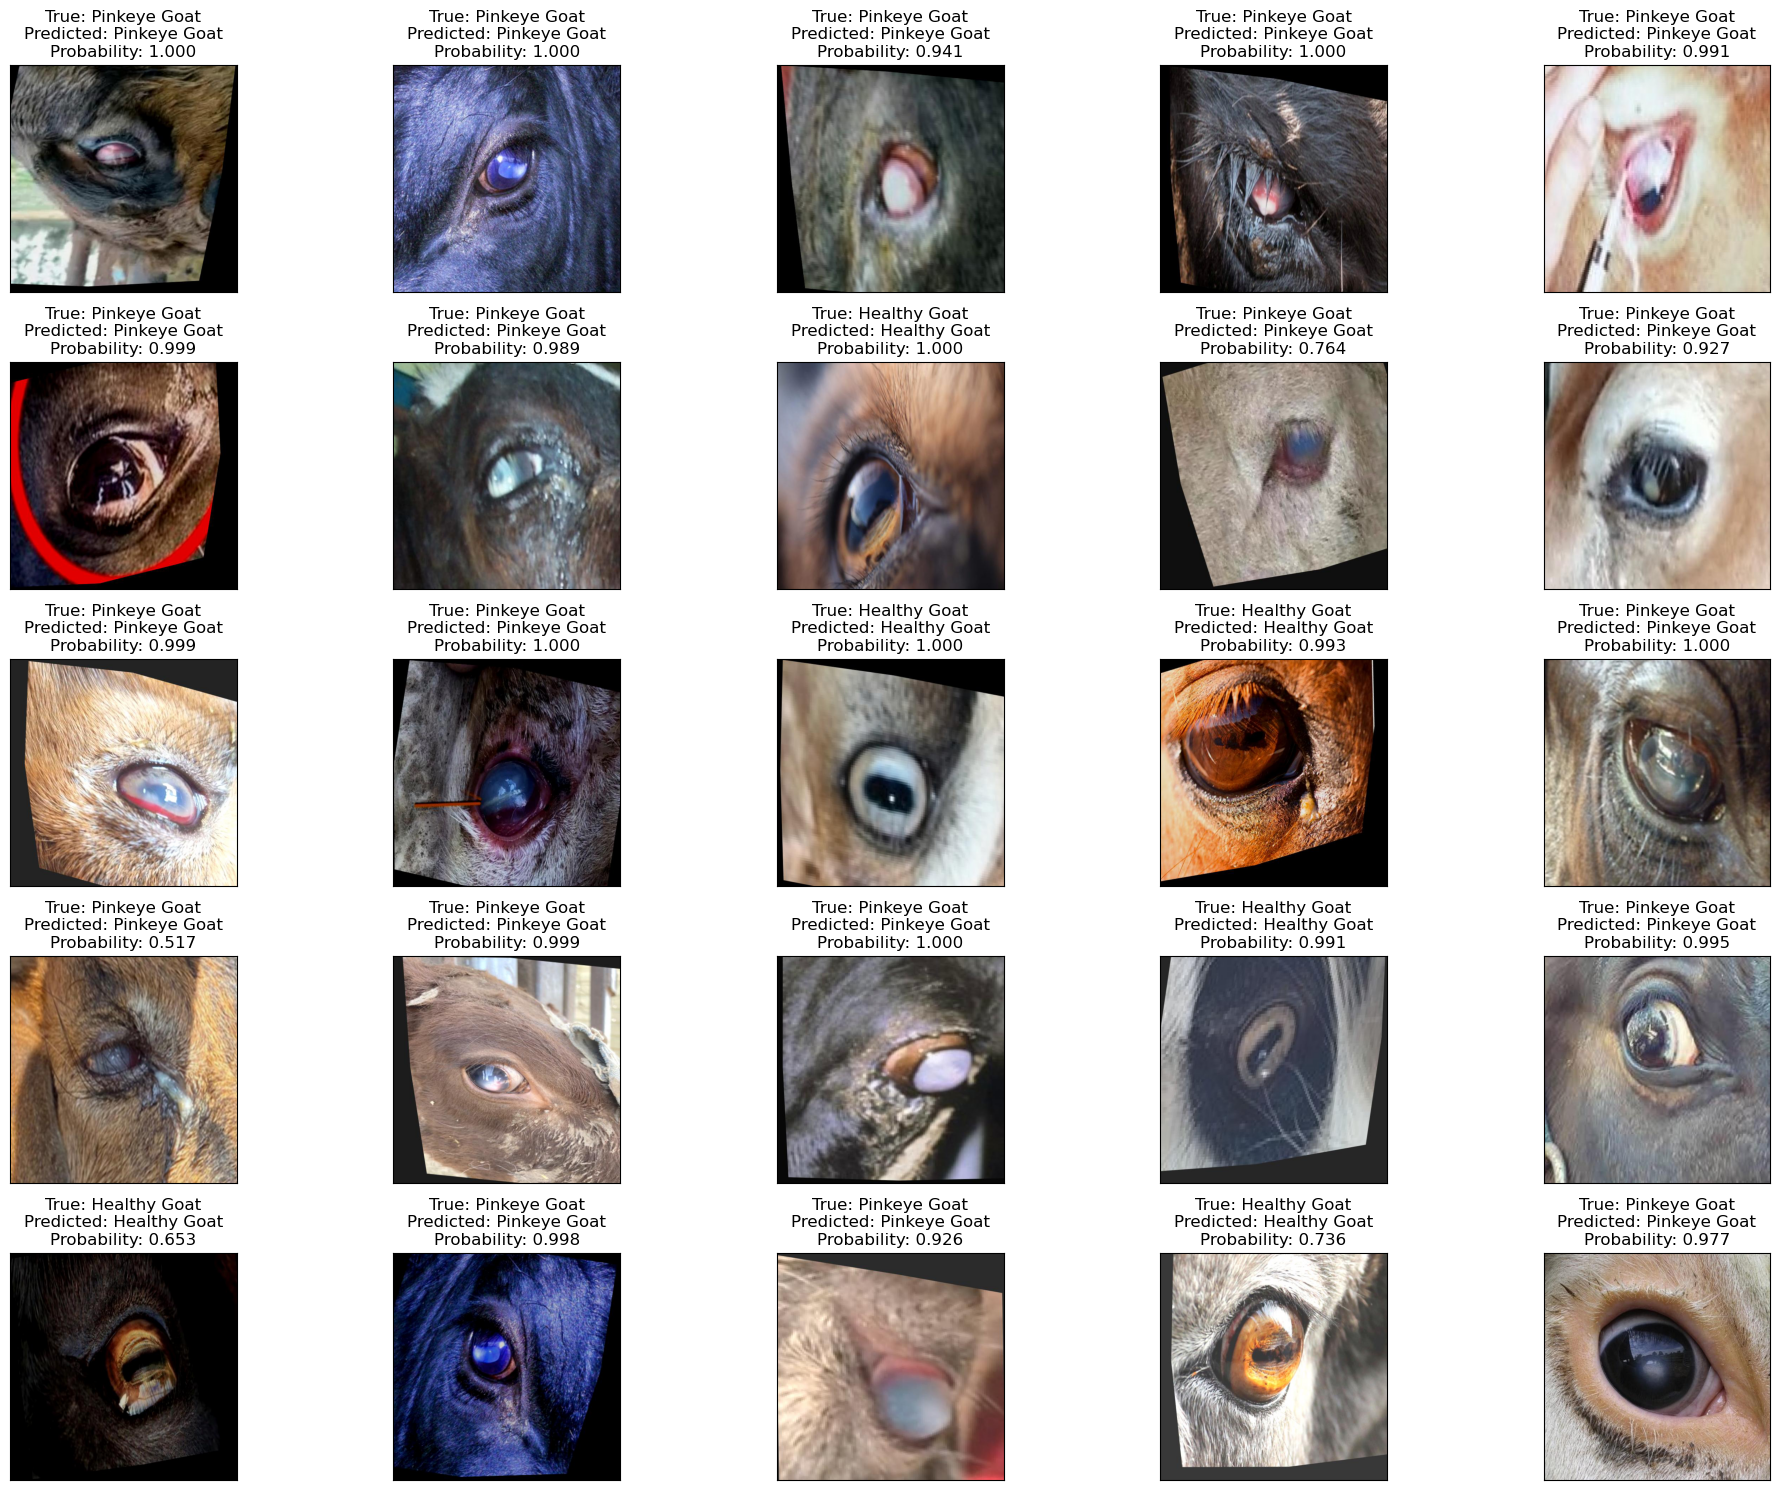

In [18]:
# Display the result
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(validasi_df.Filepath.iloc[i]))
    ax.set_title(f"True: {validasi_df.Label.iloc[i]}\nPredicted: {pred_classes[i]}\nProbability: {pred_proba[i]:.3f}")
plt.tight_layout()
plt.show()

## Convert to TFLite

In [19]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(mobileNet_model)
tflite_model = converter.convert()

with open('MobileNet_Goat_model.tflite', 'wb') as f:
  f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\FENNYP~1\AppData\Local\Temp\tmpec5ywwb0\assets


INFO:tensorflow:Assets written to: C:\Users\FENNYP~1\AppData\Local\Temp\tmpec5ywwb0\assets
